In [1]:
%matplotlib inline
from kid_readout.measurement.io import npy
from kid_readout.measurement import temperature
from kid_readout.analysis.resonator import plot_resonator
from kid_readout.analysis.timeseries import binning, iqnoise

In [2]:
npd150 = npy.NumpyDirectory('/data/detectors/2016-10-18_161556_sweep_stream_on_off/')

In [3]:
plot_directory = '/home/flanigan/temp/'

In [64]:
def analyze(ss_on, ss_off, num_averaged=8):
    nfft = int(2 ** (np.floor(np.log2(ss_on.sample_time.size)) - np.log2(num_averaged)))
    noverlap = nfft // 2
    c, f = plt.mlab.cohere(ss_on.s21_raw, ss_off.s21_raw, Fs=ss_on.stream_sample_rate,
                           NFFT=nfft, noverlap=noverlap, window=plt.mlab.window_hanning, sides='onesided')
    edges, fb, cb = binning.log_bin_everywhere(f[1:-1], 15, c[1:-1])
    return f, c, fb, cb[0]

In [54]:
def plot_coherence_on_off(on_off_coherences, num_channels, num_attenuations,
                          figsize=(num_attenuations, num_channels),
                          xlimits=(0.1, 2e4), ylimits=(1e-3, 1.5)):
    fig, axes = plt.subplots(num_channels, num_attenuations, figsize=figsize)
    axes = np.atleast_2d(axes)
    for channel in range(num_channels):
        for attenuation_index in range(num_attenuations):
            index = channel * num_attenuations + attenuation_index
            ax = axes.flatten()[index]
            f, c, fb, cb = on_off_coherences[index]
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.plot(f, c, '-', color='gray')
            ax.plot(fb, cb, '-', color='red')
            ax.set_xlim(*xlimits)
            ax.set_ylim(*ylimits)
            ax.tick_params(labelsize=4)
            if channel != num_channels - 1:
                ax.set_xticklabels([])
            if attenuation_index != 0:
                ax.set_yticklabels([])
    axes[num_channels - 1, 0].set_ylabel('coherence', fontsize=6)
    axes[num_channels - 1, 0].set_xlabel('frequency / Hz', fontsize=6)
    return fig, axes

In [14]:
num_channels = 7
num_attenuations = 4

# 150 mK

In [7]:
sss_150 = [npd150.read(name) for name in npd150.node_names() if name.startswith('SingleSweepStream')]
off_ss_150 = [npd150.read(name) for name in npd150.node_names() if name.startswith('SingleStream')]

In [16]:
assert len(sss_150) == len(off_ss_150) == num_channels * num_attenuations

In [8]:
on_ss_150 = [sss.stream for sss in sss_150]

In [69]:
on_off_coherences = [analyze(on_ss, off_ss, num_averaged=128) for on_ss, off_ss in zip(on_ss_150, off_ss_150)]

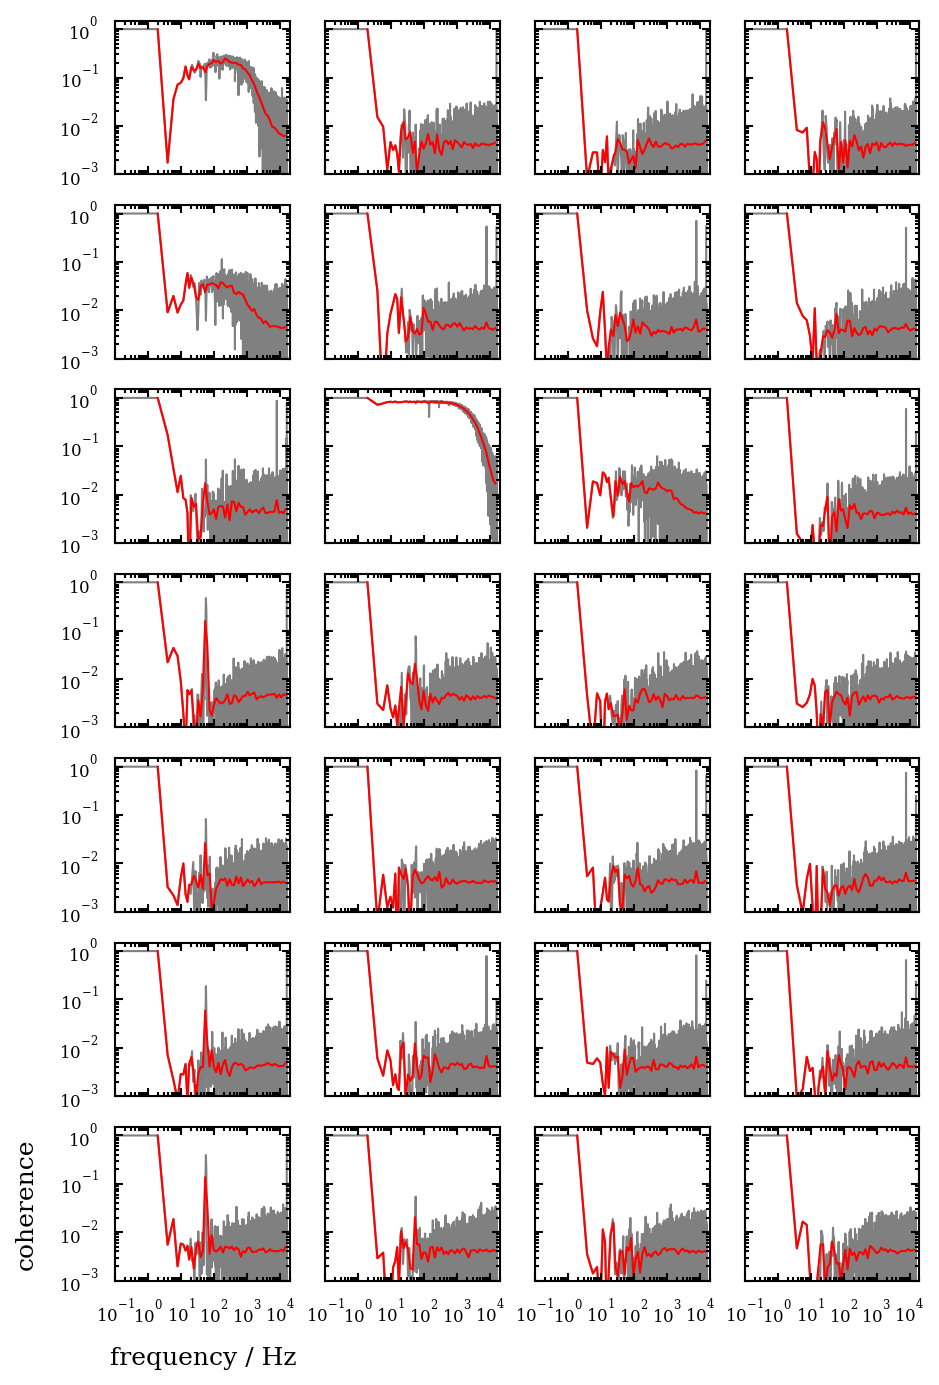

In [70]:
fig, ax = plot_coherence_on_off(on_off_coherences, num_channels, num_attenuations)

In [65]:
different0004 = analyze(on_ss_150[0], off_ss_150[4], num_averaged=128)
different0400 = analyze(on_ss_150[4], off_ss_150[0], num_averaged=128)
different1216 = analyze(on_ss_150[12], off_ss_150[16], num_averaged=128)
different1612 = analyze(on_ss_150[16], off_ss_150[12], num_averaged=128)

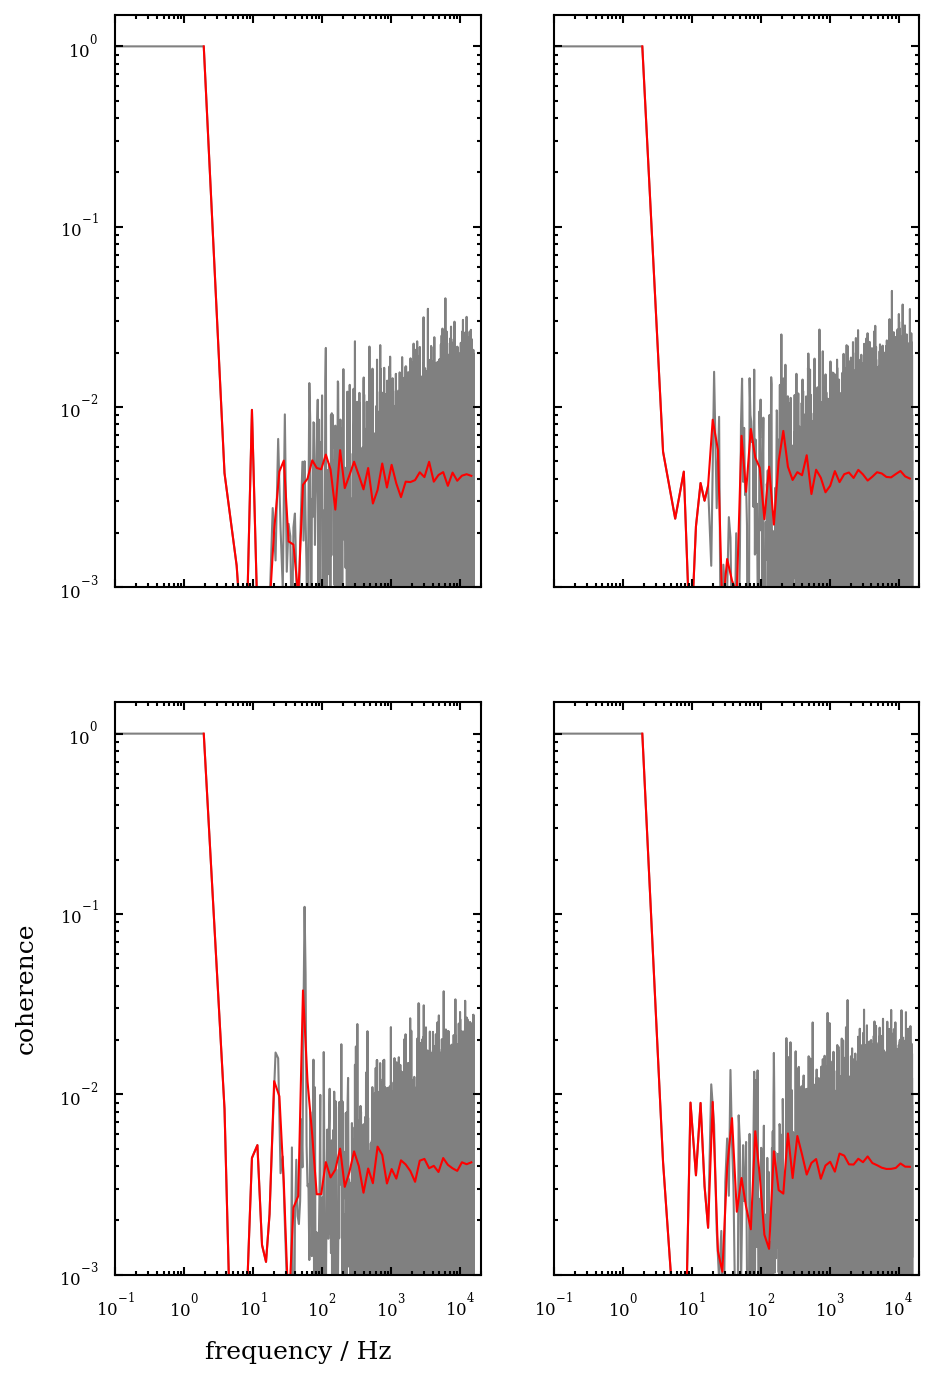

In [66]:
fig, axes = plot_coherence_on_off([different0004, different0400, different1216, different1612], 2, 2)

In [68]:
size = on_ss_150[0].s21_raw.size
np.log2(size)

21.0

In [61]:
sample_time = on_ss_150[0].sample_time
stream_sample_rate = on_ss_150[0].stream_sample_rate

In [46]:
class Dummy(object):
    pass

In [47]:
dummy0 = Dummy()
dummy1 = Dummy()

In [62]:
dummy0.s21_raw = np.random.randn(size) + 1j * np.random.randn(size)
dummy1.s21_raw = np.random.randn(size) + 1j * np.random.randn(size)
dummy0.sample_time = sample_time
dummy0.stream_sample_rate = stream_sample_rate

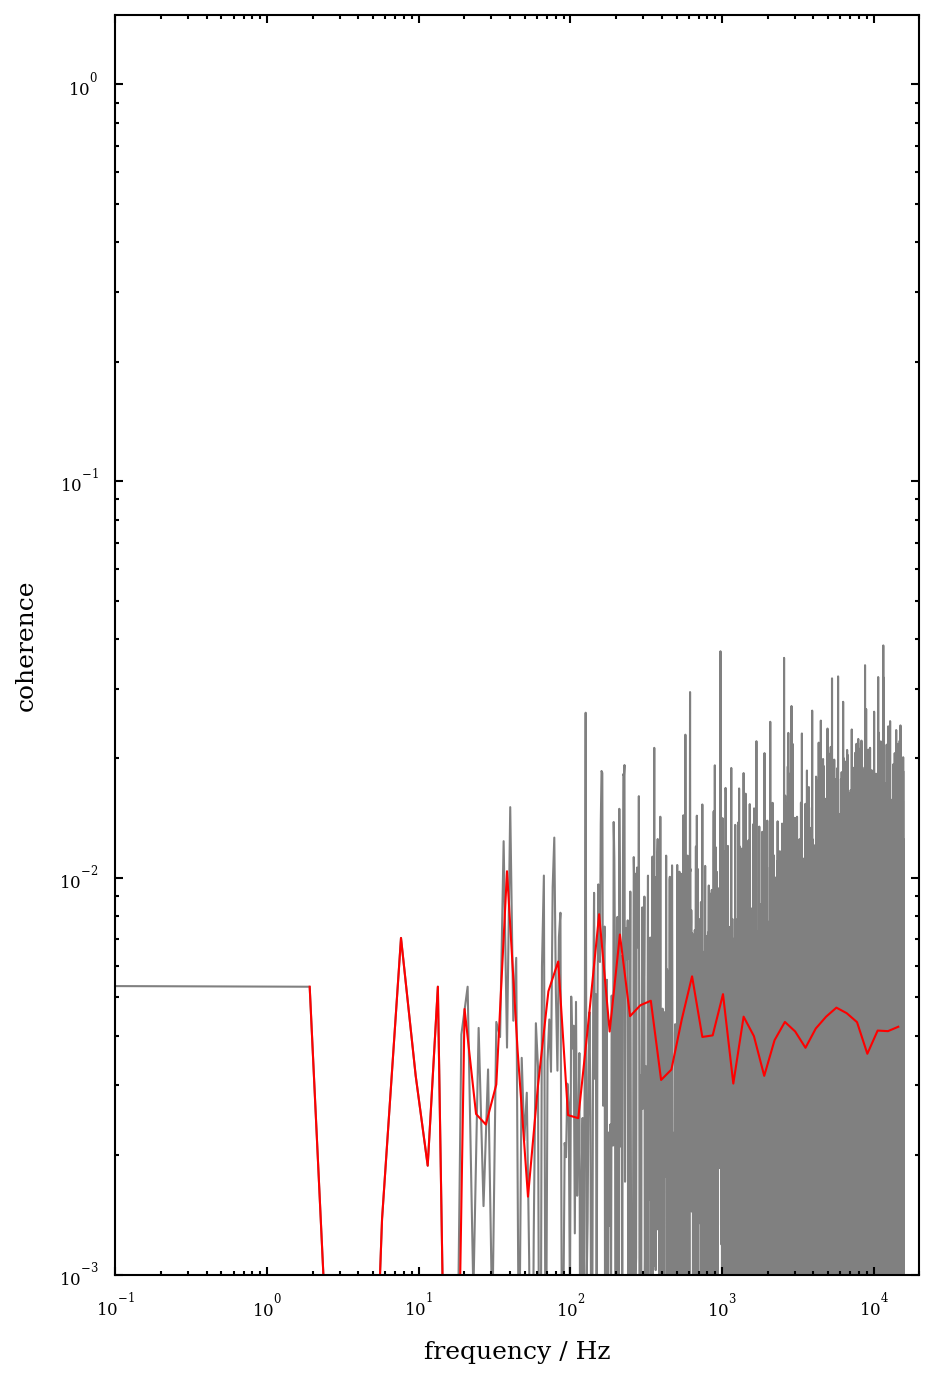

In [71]:
fig, axes = plot_coherence_on_off([analyze(dummy0, dummy1, num_averaged=128)], 1, 1)